In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

dimension = 2
datapoints = 100
gamma = 0.5

#def dividing functions for demonstration
def f(datapoint):
    result = 0
    for i in range(0, len(datapoint)):
        result += ((datapoint[i]- 0.5) ** 2)
    result -= 0.1
    return result

def g(datapoint):
    result = 0    
    for i in range(len(datapoint)):
        result += datapoint[i] * (-1) ** i
    return result


def kmeanscluster(X,J):
    X = npify(X)
    J = npify(J)
    P = J
    while True:
        C = cluster(X,J)
        for i in range(len(J)):
            npify(C[i])
            if C[i] != []:
                P[i] = clustermean(C[i])
        if P == J:
            break
        else: J = P
    for i in range(len(C)):
        for j in range(len(C[i])):
            C[i][j] = list(C[i][j])
    return C

def cluster(X,J):
    clusters = []
    P = []
    for i in range(len(J)):
        clusters.append([])
    Z = distance(J,X)
    for i in range(len(X)):
        Q = []
        for j in range(len(J)):
            Q.append(Z[j][i])
        q = min(Q)
        p = Q.index(q)
        clusters[p].append(X[i])
    return clusters   

def clustermean(x):
    if x != []:
        k = x[0]
        k = np.array(k)
        for i in range(1, len(x)):
            k = k + np.array(x[i])
        k = k/len(x)
        return k
    else:
        return "empty"
    
def npify(x):
    y = x
    for i in range (0, len(x)):
        y[i] = np.array(x[i])
    return y

def distance(J,y):
    Z = np.empty((len(J),len(y)))
    for j in range(0,len(J)):
        for i in range(0, len(y)):
            Z[j,i]=np.linalg.norm(y[i]-J[j])
    return Z

def makedata(datapoints, f):
    Data = []
    Y = []
    for i in range(datapoints):
        Data.append(np.random.uniform(0, 1, dimension))
        if f(Data[i]) <= 0:
            Y.append(-1)
        else:
            Y.append(1)   
    return Data, Y

def plot(Data, Yi):
    for i in range(len(Data)):
        if Yi[i] == 1:
            colour = 'r'
        else:
            colour = 'b'
        plt.scatter(Data[i][0], Data[i][1], color = colour)
        
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    
def randomJ(k):
    clustermeans = []
    for i in range(k):
        clustermeans.append(np.random.uniform(0, 1, 2))
    return clustermeans

def getclustermeans(Data, k):
    clusters = kmeanscluster(Data, randomJ(k))
    clustermeans = []
    for i in clusters:
        clustermeans.append(clustermean(i))
    return clustermeans


def getweights(Data, Y, k, gamma, clustermeans):
    phi = np.empty((len(Data), k))
    for i in range(len(phi)):
        for j in range(len(phi[i])):
            phi[i][j] = np.exp(-gamma * np.linalg.norm(Data[i] - clustermeans[j]))
            
    pp = np.matmul(np.transpose(phi), phi)
    pseudoinv = np.matmul(np.linalg.inv(pp), np.transpose(phi))
    W = np.matmul(pseudoinv, Y)
    return W


def getgamma(Data, Y, k, W, clustermeans, stepsize, steps, initial):
       
    gamma = 1
    
    for i in range(steps):
        hypotheses1 = []
        hypotheses2 = []
        hypotheses3 = []
        for point in Data:
            hypotheses1.append(np.sign(hypothesis(point, W, clustermeans, gamma + initial * stepsize ** i)))
            hypotheses2.append(np.sign(hypothesis(point, W, clustermeans, gamma - initial * stepsize ** i)))
            hypotheses3.append(np.sign(hypothesis(point, W, clustermeans, gamma)))
            
        error1 = 0
        error2 = 0
        error3 = 0
        for i in range(len(Y)):
            if hypotheses1[i] != Y[i]:
                error1 += 1
            if hypotheses2[i] != Y[i]:
                error2 += 1
            if hypotheses3[i] != Y[i]:
                error3 += 1

        besterror = min(error1, error2, error3)
        if besterror == error3:
            pass
        elif besterror == error2:
            gamma = gamma - initial * stepsize ** i
        elif besterror == error1:
            gamma = gamma + initial * stepsize ** i
            
    return gamma
    

def hypothesis(x, W, clustermeans, gamma):
    x = np.array(x)
    clustermeans = np.array(clustermeans)
    W = np.array(W)
    h = 0
    for i in range(len(clustermeans)):
        h += W[i] * np.exp( - gamma * np.linalg.norm(x - clustermeans[i]) ** 2)
    return h


def RBF(Data, Y, iterations, k, stepsize, steps, initial):
    clustermeans = getclustermeans(Data, k)
    gamma = 1
    for i in range(iterations):
        W = getweights(Data, Y, k, gamma, clustermeans)
        gamma = getgamma(Data, Y, k, W, clustermeans, stepsize, steps, initial)
        
    hypotheses = []
    for i in Data:
        hypotheses.append(np.sign(hypothesis(i, W, clustermeans, gamma)))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    u = np.linspace(0, 1, 100)
    x, y = np.meshgrid(u, u)
    plotgrid = []
    
    for i in range(100):
        plotgrid.append([])
    for i in range(100):
        for j in range(100):
            X = np.array([x[i][j], x[j][i]])
            hyp = hypothesis(X, W, clustermeans, gamma)
            plotgrid[i].append(hyp)
    
    for i in range(len(Data)):
        if Y[i] == 1:
            colour = 'r'
        else:
            colour = 'b'
        plt.scatter(Data[i][0], Data[i][1], color = colour)
        
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
        
    ax.contour(x, y, plotgrid, levels = [0])
    
    plt.xlabel('Dividing line on the actual data')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    u = np.linspace(0, 1, 100)
    x, y = np.meshgrid(u, u)
    plotgrid = []
    
    for i in range(100):
        plotgrid.append([])
    for i in range(100):
        for j in range(100):
            X = np.array([x[i][j], x[j][i]])
            hyp = hypothesis(X, W, clustermeans, gamma)
            plotgrid[i].append(hyp)
    
    for i in range(len(Data)):
        if hypotheses[i] == 1:
            colour = 'r'
        else:
            colour = 'b'
        plt.scatter(Data[i][0], Data[i][1], color = colour)
        
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
        
    ax.contour(x, y, plotgrid, levels = [0])
    
    plt.xlabel('Dividing line on the data predicted by model')
    plt.show()
    
    return W, gamma

In [315]:
#2 sets of randomly generated data, each divided into 2 groups in a different way.
Data1, Y1 = makedata(100, f)
Data2, Y2 = makedata(100, g)

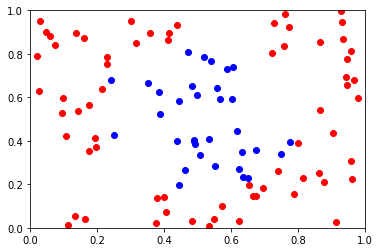

In [316]:
#plot of the first dataset...
plot(Data1, Y1)

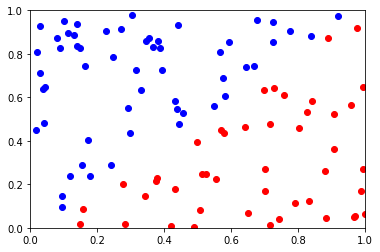

In [317]:
#and the second!
plot(Data2, Y2)

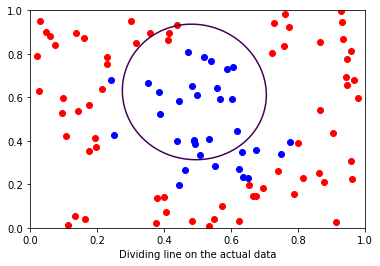

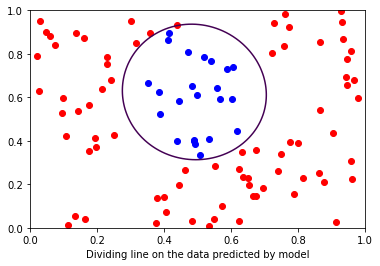

(array([ -2.7803947 ,  -8.96196114,   3.6970982 ,   8.60111243,
          0.3817176 ,   5.85233952, -10.35509673,   3.1131315 ,
          5.0370236 ,  -1.99925596]), 1)

In [319]:
#running RBF on the first dataset
RBF(Data1, Y1, 30, 10, 0.9, 20, 1)

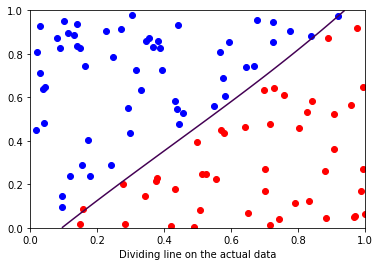

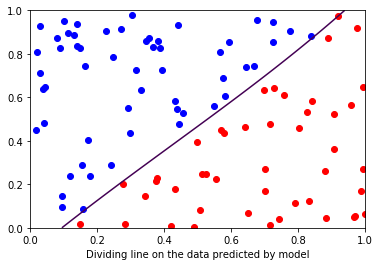

(array([ 1.24965932, -0.17080914, -0.57347169,  4.60267971,  2.39600617,
         5.17991758, -1.84979887, -0.88243157, -3.62175959, -6.27896277]),
 1.0005902533086122)

In [320]:
#and the second!
RBF(Data2, Y2, 30, 10, 0.9, 20, 1)